In [293]:

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

bit = 2
x_range = 2**bit-1

prefix = f'./{bit}bit/MSEQuant.'
delta = torch.load(f'{prefix}delta.pt').detach()
zero = torch.load(f'{prefix}raw_zero_point.pt').detach()
weight = torch.load(f'{prefix}weight.pt').detach()

# delta  = delta[:8, :1, :1, :1]
# zero   = zero[:8, :1, :1, :1]
# weight = weight[:8, :1, :, :]

print("Shape of delta:", delta.shape)
print("Shape of zero:", zero.shape)
print("Shape of weight:", weight.shape)
print(weight[0, 0, 0, :])



Shape of delta: torch.Size([512, 1, 1, 1])
Shape of zero: torch.Size([512, 1, 1, 1])
Shape of weight: torch.Size([512, 256, 3, 3])
tensor([-0.0015, -0.0019, -0.0013], device='cuda:1')


In [294]:
def find_inp_scale(x, delta, zero, level):
    #Configuration
    global x_range
    
    #Options
    min_lim = 0.0 - 0.5/x_range*1.5
    max_lim = 1.0 + 0.5/x_range*1.5
    
    inp_scale_shape = (1, x.shape[1], x.shape[2], x.shape[3])
    max_inp_scale = torch.ones(inp_scale_shape, device=x.device)
    candi =  [i/level for i in range(level, 0, -1)]
    print(f"level : {level} Candis : ", candi)
    
    for c in candi:
        inp_scale = torch.full(inp_scale_shape, c, device=x.device)
        x_int = x/inp_scale/delta + zero
        x_quant = x_int/x_range
        min_x_quant = torch.min(x_quant, dim=0, keepdim=True)[0]
        max_x_quant = torch.max(x_quant, dim=0, keepdim=True)[0]
        max_inp_scale = torch.where((min_x_quant > min_lim) & (max_x_quant < max_lim), inp_scale, max_inp_scale)
    return max_inp_scale

def mse_quant(x, delta, zero, level):
    global x_range
    zero = torch.round(zero/delta)
    inp_scale = find_inp_scale(x, delta, zero, level)
    # x_int = x/inp_scale/delta + zero
    # x_quant = x_int/x_range
    # x_int = torch.round((x/inp_scale+(zero*delta))/delta)
    x_int = torch.round(x/inp_scale/delta) + zero
    x_quant = torch.clamp(x_int, 0, x_range)
    return x_quant, inp_scale

def mse_calc(x, x_quant, delta, zero, inp_scale):
    zero = torch.round(zero/delta)
    x_float = (x_quant - zero) * delta * inp_scale
    mse = torch.mean(torch.square(x_float - x)).item()
    # print(zero[0, 0, 0, 0])
    # print(delta[0, 0, 0, 0])
    # print(inp_scale[0, 0, 0, 0])
    # print(x_float[0, 0, 0, :], x[0, 0, 0, :])
    print("MSE:", mse)
    return mse

mses = []
for i in range(11):
    level = 2**i
    print("Level:", level)
    x_quant, inp_scale = mse_quant(weight, delta, zero, level)
    mse = mse_calc(weight, x_quant, delta, zero, inp_scale)
    mses.append(mse)
print(mses)
    
    

Level: 1
level : 1 Candis :  [1.0]
MSE: 7.360761173913488e-06
Level: 2
level : 2 Candis :  [1.0, 0.5]
MSE: 5.132118531037122e-06
Level: 4
level : 4 Candis :  [1.0, 0.75, 0.5, 0.25]
MSE: 3.710291366587626e-06
Level: 8
level : 8 Candis :  [1.0, 0.875, 0.75, 0.625, 0.5, 0.375, 0.25, 0.125]
MSE: 2.980335239044507e-06
Level: 16
level : 16 Candis :  [1.0, 0.9375, 0.875, 0.8125, 0.75, 0.6875, 0.625, 0.5625, 0.5, 0.4375, 0.375, 0.3125, 0.25, 0.1875, 0.125, 0.0625]
MSE: 2.695014700293541e-06
Level: 32
level : 32 Candis :  [1.0, 0.96875, 0.9375, 0.90625, 0.875, 0.84375, 0.8125, 0.78125, 0.75, 0.71875, 0.6875, 0.65625, 0.625, 0.59375, 0.5625, 0.53125, 0.5, 0.46875, 0.4375, 0.40625, 0.375, 0.34375, 0.3125, 0.28125, 0.25, 0.21875, 0.1875, 0.15625, 0.125, 0.09375, 0.0625, 0.03125]
MSE: 2.5606357212382136e-06
Level: 64
level : 64 Candis :  [1.0, 0.984375, 0.96875, 0.953125, 0.9375, 0.921875, 0.90625, 0.890625, 0.875, 0.859375, 0.84375, 0.828125, 0.8125, 0.796875, 0.78125, 0.765625, 0.75, 0.734375, 0.

(512, 2304)


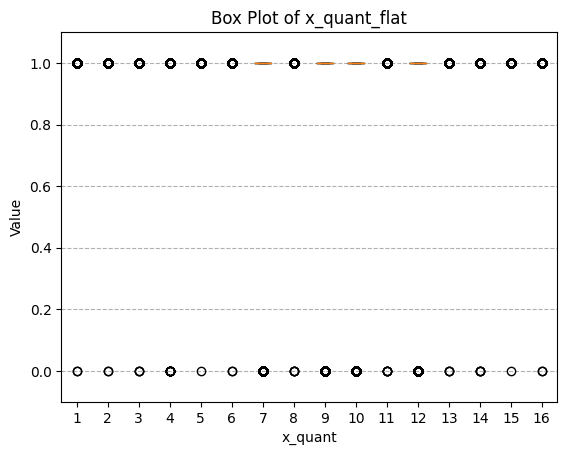

In [266]:
import seaborn as sns
# Flatten the tensor to 1D
# print(x_quant)
x_quant_flat = x_quant.reshape(x_quant.shape[0], -1).cpu().numpy()

print(x_quant_flat.shape)
# print(x_quant_flat)
plt.boxplot(x_quant_flat[:16].T)

plt.ylim(-0.1, 1.1)
plt.grid(axis='y', linestyle='--')
plt.xlabel('x_quant')
plt.ylabel('Value')
plt.title('Box Plot of x_quant_flat')
plt.show()

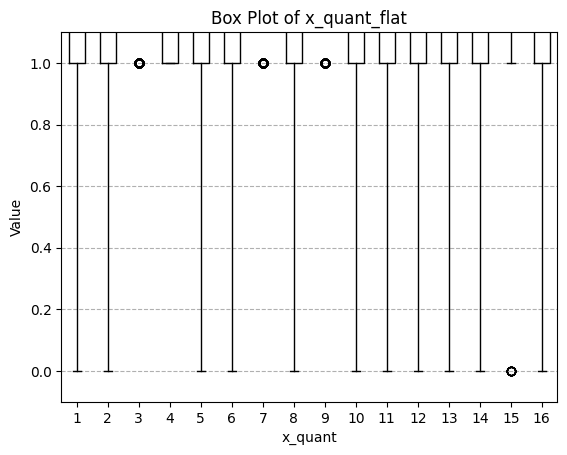

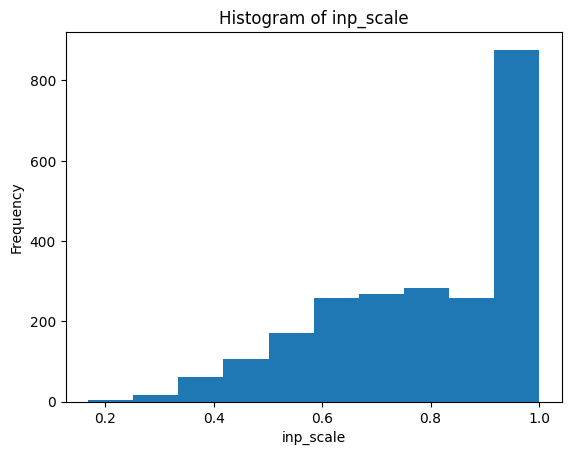

In [267]:
# Flatten the tensor to 1D
# print(x_quant[10, 4, : , :])

# print(x_quant)

# x_quant_flat = x_quant.view(x_quant.shape[0], -1).cpu().numpy()

# FILEPATH: /home/jai1215/project/quant/ShiftedScaleQuant/23_11_23_MSE_Scale_Test/MSEQuant.ipynb
# Draw the kde plot

plt.boxplot(x_quant_flat[:, :16])
plt.ylim(-0.1, 1.1)
# plt.ylim(-0.7, 1.7)
plt.grid(axis='y', linestyle='--')
plt.xlabel('x_quant')
plt.ylabel('Value')
plt.title('Box Plot of x_quant_flat')
plt.show()



plt.hist(inp_scale.cpu().numpy().flatten(), bins=10)
plt.xlabel('inp_scale')
plt.ylabel('Frequency')
plt.title('Histogram of inp_scale')
plt.show()

# for i in range(16):
#     sns.kdeplot(x_quant_flat[i], shade=True, label=f'x_quant[{i}]')

# plt.xlabel('Value')
# plt.ylabel('Density')
# plt.title('KDE Plot of x_quant')
# plt.show()